In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

In [2]:
SKAB = pd.read_table('https://raw.githubusercontent.com/waico/SKAB/master/data/valve1/0.csv', sep=";").drop(['datetime', 'changepoint'], axis=1)

In [3]:
SKAB.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1147 entries, 0 to 1146
Data columns (total 9 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Accelerometer1RMS    1147 non-null   float64
 1   Accelerometer2RMS    1147 non-null   float64
 2   Current              1147 non-null   float64
 3   Pressure             1147 non-null   float64
 4   Temperature          1147 non-null   float64
 5   Thermocouple         1147 non-null   float64
 6   Voltage              1147 non-null   float64
 7   Volume Flow RateRMS  1147 non-null   float64
 8   anomaly              1147 non-null   float64
dtypes: float64(9)
memory usage: 80.8 KB


In [4]:
SKAB.nunique()

Accelerometer1RMS      1100
Accelerometer2RMS      1131
Current                1140
Pressure                  5
Temperature            1124
Thermocouple            866
Voltage                1126
Volume Flow RateRMS      42
anomaly                   2
dtype: int64

In [5]:
X = SKAB.drop('anomaly', axis=1)
y = SKAB['anomaly']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)


sc = StandardScaler()
X_train_sc = sc.fit_transform(X_train)
X_test_sc = sc.transform(X_test)

In [6]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score

In [7]:
from sklearn.tree import DecisionTreeClassifier

param_grid = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

model = DecisionTreeClassifier()
gs = GridSearchCV(estimator=model, param_grid=param_grid, scoring='accuracy', cv=5)
gs.fit(X_train_sc, y_train)

best_param = gs.best_params_
best_score = gs.best_score_

best_model = gs.best_estimator_
y_pred = best_model.predict(X_test_sc)
accuracy = accuracy_score(y_test, y_pred)


print(accuracy)

0.9434782608695652


In [8]:
print(best_model)

DecisionTreeClassifier(criterion='entropy', max_depth=10)


In [9]:
pip install shap

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 540.5/540.5 kB 2.8 MB/s eta 0:00:00


In [10]:
import shap

In [11]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score

param_grid = {
    'n_estimators': [100, 200, 300],
    'criterion': ['gini', 'entropy'],
    'max_depth': [None, 10, 20, 30],
    # 'min_samples_split': [2, 5, 10],
    # 'min_samples_leaf': [1, 2, 4],
    # 'bootstrap': [True, False]
}

model = RandomForestClassifier()
gs = GridSearchCV(estimator=model, param_grid=param_grid, scoring='accuracy', cv=5)
gs.fit(X_train_sc, y_train)

best_param = gs.best_params_
best_score = gs.best_score_

best_model = gs.best_estimator_
y_pred = best_model.predict(X_test_sc)
accuracy = accuracy_score(y_test, y_pred)

print("Best Parameters:", best_param)
print("Best Cross-Validation Score:", best_score)
print("Test Accuracy:", accuracy)

Best Parameters: {'criterion': 'gini', 'max_depth': 30, 'n_estimators': 200}
Best Cross-Validation Score: 0.960721073889285
Test Accuracy: 0.9521739130434783


In [ ]:
features = SKAB.columns
#ランダムフォレストの結果から，変数の重要度を読み込む
importances = best_model.feature_importances_
#重要度の順番を降順に確認する
indices = np.argsort(importances)

#重要度を降順に並び替え横棒プロットする
plt.figure(figsize=(10,10))
plt.barh(range(len(indices)), importances[indices])
plt.yticks(range(len(indices)), features[indices])
plt.show()

In [13]:
explainer = shap.KernelExplainer(best_model.predict_proba, X_train_sc)
shap_values = explainer.shap_values(X_train_sc, check_additivity=False)

  0%|          | 0/917 [00:00<?, ?it/s]

In [15]:
shap.plots.waterfall(shap_values)

TypeError: The waterfall plot requires an `Explanation` object as the `shap_values` argument.

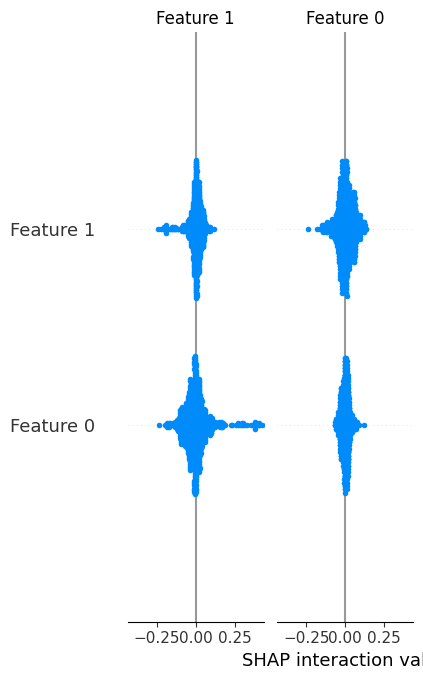

In [18]:
shap.summary_plot(shap_values)

In [19]:

import xgboost as xb
from sklearn.metrics import confusion_matrix

In [20]:
#必要なライブラリの読み込み
import xgboost as xgb

#Xgboostによるモデリング
#Xgboostでは独自のDMatrix形式を用いる．とはいっても通王のnumpy配列から以下のように変換できる．
dtrain = xgb.DMatrix(X_train_sc, label=y_train)


xgb_params = {'max_depth': 3,
              'eta': 0.1,
              'objective': 'multi:softmax',
              'num_class': 2}
#学習の実行．繰り返し計算数1000
gbm = xgb.train(xgb_params, dtrain, num_boost_round=1000)
#テストデータもDMatrix形式に
dtest = xgb.DMatrix(X_test_sc)
#予測
pred = gbm.predict(dtest)

#混合行列で精度を確認する
mat = confusion_matrix(y_test, pred)

#pandasで表の形に
df = pd.DataFrame(mat)
print(df)

     0   1
0  155   3
1    5  67


In [21]:
from sklearn.metrics import f1_score
print(f1_score(y_test, pred, average="macro"))

0.9592523695632917


In [ ]:
# explainer = shap.TreeExplainer(gbm)

# # テストデータに対するSHAP値を計算
# shap_values = explainer.shap_values(dtest)

# # SHAP summary plotの表示
# shap.summary_plot(shap_values, X_test_sc)

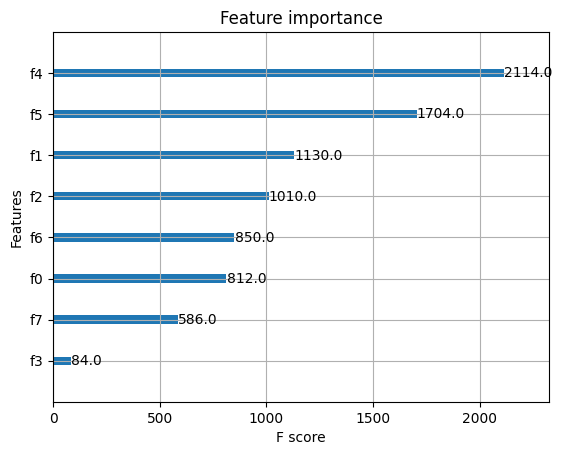

In [22]:
xgb.plot_importance(gbm)
plt.show()